# PythonFMU example

This is an example on how to use PythonFMU in order to export a Python script as a FMI 2.0 for CoSimulation compliant FMU.

## Installation

But first thing first, you will need the `pythonfmu` Python package. To install it, you can use the pip package manager:

```bash
python -m pip install pythonfmu
```

## The to-be-exported script

To export Python code as FMU, you will need to interface your code with the FMI facade provided through an abstract class `pythonfmu.Fmi2Slave`.

In the following example, you will interface a simple resistor code.

In [1]:
%pycat demoslave.py

from pythonfmu import Fmi2Causality, Fmi2Variability, Fmi2Slave, Real


class Resistor(Fmi2Slave):

    author = "John Doe"
    description = "A simple description"

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.positive_pin_v = 20.
        self.positive_pin_i = 0.001
        self.negative_pin_v = 10.
        self.negative_pin_i = 0.001
        self.delta_v = 10.
        self.i = 0.001
        self.R = 10000.
        
        self.register_variable(Real("R", causality=Fmi2Causality.parameter, variability=Fmi2Variability.tunable))

        self.register_variable(Real("positive_pin_v", causality=Fmi2Causality.input))
        self.register_variable(Real("positive_pin_i", causality=Fmi2Causality.output))
        self.register_variable(Real("negative_pin_v", causality=Fmi2Causality.input))
        self.register_variable(Real("negative_pin_i", causality=Fmi2Causality.output))

        self.register_variable(Real("delta_v", causality=Fmi2Causality.local))


## Generate the FMU

The FMU is generated through the command line tool `pythonfmu build`.

In [2]:
!pythonfmu build -f ./demoslave.py --no-external-tool

The mandatory information to pass to the builder is the Python script file through the `-f` option. 

> By default the generated FMU states that a external tool (i.e. Python) is needed for its execution. But the usage of the FMU is demonstrated through `pyfmi` that does not support that feature. This is the reason the option `--no-external-tool` is provided.

The full list of available options is:

In [3]:
!pythonfmu build -h

usage: pythonfmu build [-h] [-v] -f SCRIPT_FILE [-d DEST]
                         [--doc DOCUMENTATION_FOLDER] [--no-external-tool]
                         [--no-variable-step] [--interpolate-inputs]
                         [--only-one-per-process] [--handle-state]
                         [--serialize-state] [--use-memory-management]
                         [Project files [Project files ...]]

Build a FMU from a Python script.

positional arguments:
  Project files         Additional project files required by the Python
                        script.

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit
  -f SCRIPT_FILE, --file SCRIPT_FILE
                        Path to the Python script.
  -d DEST, --dest DEST  Where to save the FMU.
  --doc DOCUMENTATION_FOLDER
                        Documentation folder to include in the FMU.
  --no-external-tool    If given, needsExecutionTool=false
  --no

## Use the FMU

You can now use the FMU. For example through the `pyfmi` Python package:

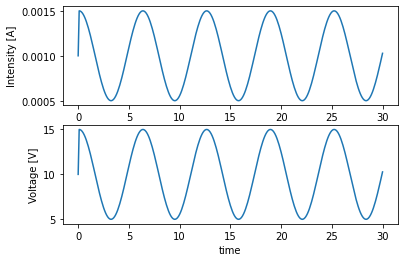

In [4]:
%matplotlib inline

from pyfmi import load_fmu

import matplotlib.pyplot as p
import numpy

model = load_fmu('Resistor.fmu')

inputs = ('positive_pin_v', lambda t: 20 + 5. * numpy.cos(t))

res = model.simulate(final_time=30, input=inputs, options={'ncp': 300})

fig = p.figure()
ax1 = p.subplot(2, 1, 1)
ax1.plot(res['time'], res['i'])
ax1.set_ylabel('Intensity [A]')
ax2 = p.subplot(2, 1, 2)
ax2.plot(res['time'], res['delta_v'])
ax2.set_xlabel('time')
ax2.set_ylabel('Voltage [V]')
p.show();

The code specifies a *parameter*, which you could change:

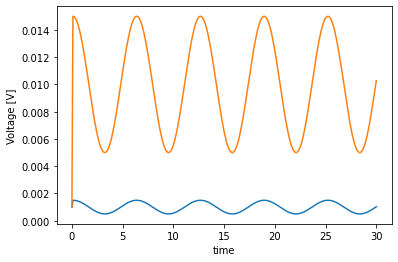

In [5]:
R_reference = model.get_model_variables()['R'].value_reference
model.set_real([R_reference, ], [1000., ])

res2 = model.simulate(final_time=30, input=inputs, options={'ncp': 300})

fig = p.figure()
p.plot(res['time'], res['i'], res2['time'], res2['i'])
p.xlabel('time')
p.ylabel('Voltage [V]')
p.show();

In [6]:
model.free_instance()  # It is currently not possible to load two Python FMUs simultaneously

## Install FMU dependencies

Python script can use third-party libraries. PythonFMU does not include such dependencies within the FMU. So it is up to the end user to installed the dependent packages.

However to help the process, you could include as project file in your FMU a requirement file. Then the end user will be able to install the dependencies using the `pythonfmu deploy` tool. The tool supports for now two packages manager: `pip` and `conda`. Moreover if you use the default convention for naming the requirement file (i.e. *requirements.txt* for `pip` and *environment.yml* for `conda`), the end user won't need to specify the file name nor the package manager to be used.

In the following paragraphs, an example requiring `scipy` will be demonstated. The Python facade is defined in the `scipyslave.py` file and the requirement are provided in `environment.yml` for usage with `conda`.

In [7]:
!pythonfmu deploy -h

usage: pythonfmu deploy [-h] [-v] -f FMU [-e ENVIRONMENT] [{pip,conda}]

Deploy a Python FMU. The command will look in the `resources` folder for one
of the following files: - `requirements.txt`: Install dependencies using pip
package manager - `environment.yaml`: Update the current environment using the
conda package manager If you specify a environment file but no package
manager, `conda` will be selected for `.yaml` and `.yml` otherwise `pip` will
be used. The tool assume the Python environment in which the FMU should be
executed is the current one.

positional arguments:
  {pip,conda}           Python packages manager

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit
  -f FMU, --file FMU    Path to the Python FMU.
  -e ENVIRONMENT, --env ENVIRONMENT
                        Requirements or environment file.


### Include the requirement file

In [8]:
!pythonfmu build -f sympyslave.py environment.yml --no-external-tool

## Installation by the end user

`scipy` is not yet installed. So the FMU cannot be executed.

In [9]:
%matplotlib inline

from pyfmi import load_fmu

import matplotlib.pyplot as p
import numpy

sympy_model = load_fmu('SympySlave.fmu')

inputs = ('realIn', lambda t: 5.)

sympy_model.simulate(final_time=30, input=inputs, options={'ncp': 300});

Simulation terminated prematurely. See the log for possibly more information. Return flag 4.


To install the FMU dependencies, the end user will need to execute:

In [10]:
!pythonfmu deploy -f SympySlave.fmu

Solving environment: ...working... done
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


The FMU can now be executed.